# Model Loading

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [2]:
from networks_pyg.GCN import *
from datasets.Myloader import traffic_mtsc_loader
# from optim import Mytrainer
# from optim.loss import loss_function,init_center
# from datasets import dataloader_pyg as dataloader
# from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [5]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'



## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of filtered Events =  849


In [6]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [7]:
def evaluate(true, pred, score, adjust = False, plot=False, print_=False):
#     true = label_all
#     pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    # auc = roc_auc_score(true, pred)
    auc = roc_auc_score(true, score)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    weighted_f1 = f1_score(true, pred, average='weighted')
    ap = average_precision_score(true, score)
    # ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(acc))
        print('AUC score \t{:.4f}'.format(auc))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(pre))
        print('Recall   \t{:.4f}'.format(rec))
        print('Macro F1 \t{:.4f}'.format(macro_f1))
        print('weighted F1 \t{:.4f}'.format(weighted_f1))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, weighted_f1, ap]

# Dataset Loading

### Anomaly Ratio Check

In [9]:
for target_sid in ['1210005301', '1030001902', '1220005401', '1210003000', '1130052300']:
    args.dataset = '{}_mtsc'.format(target_sid)
    print(args.dataset)
    train_loader, val_loader, test_loader = traffic_mtsc_loader(args)

    y_all = []
    for data in train_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    train_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1], y_all[1].sum())

    y_all = []
    for data in val_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    if len(y_all[1]) == 1:
        val_ratio = 0
    else:
        val_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1], y_all[1].sum())
    
    y_all = []
    for data in test_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    if len(y_all[1]) == 1:
        test_ratio = 0
    else:
        test_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1], y_all[1].sum())

    print(train_ratio, val_ratio, test_ratio)



1210005301_mtsc
train dataset


  0%|          | 0/5296 [00:00<?, ?it/s]100%|██████████| 5296/5296 [00:01<00:00, 3523.36it/s]


val dataset


100%|██████████| 1806/1806 [00:00<00:00, 3781.59it/s]


test dataset


100%|██████████| 1708/1708 [00:00<00:00, 2623.17it/s]


tensor([5178,  118]) tensor(5296)
tensor([1569,  237]) tensor(1806)
tensor([1401,  307]) tensor(1708)
tensor(0.0223) tensor(0.1312) tensor(0.1797)
1030001902_mtsc
train dataset


100%|██████████| 5719/5719 [00:01<00:00, 3858.41it/s]


val dataset


100%|██████████| 1070/1070 [00:00<00:00, 3709.60it/s]


test dataset


100%|██████████| 1490/1490 [00:00<00:00, 3778.59it/s]


tensor([5563,  156]) tensor(5719)
tensor([841, 229]) tensor(1070)
tensor([1237,  253]) tensor(1490)
tensor(0.0273) tensor(0.2140) tensor(0.1698)
1220005401_mtsc
train dataset


100%|██████████| 10568/10568 [00:02<00:00, 3584.64it/s]


val dataset


100%|██████████| 2682/2682 [00:00<00:00, 4022.68it/s]


test dataset


100%|██████████| 2840/2840 [00:00<00:00, 3151.18it/s]


tensor([10451,   117]) tensor(10568)
tensor([2567,  115]) tensor(2682)
tensor([2686,  154]) tensor(2840)
tensor(0.0111) tensor(0.0429) tensor(0.0542)
1210003000_mtsc
train dataset


100%|██████████| 8576/8576 [00:02<00:00, 4247.13it/s]


val dataset


100%|██████████| 2153/2153 [00:00<00:00, 4060.15it/s]


test dataset


100%|██████████| 1890/1890 [00:00<00:00, 2779.40it/s]


tensor([8378,  198]) tensor(8576)
tensor([2153]) tensor(2153)
tensor([1735,  155]) tensor(1890)
tensor(0.0231) 0 tensor(0.0820)
1130052300_mtsc
train dataset


100%|██████████| 4552/4552 [00:01<00:00, 3925.88it/s]


val dataset


100%|██████████| 1434/1434 [00:00<00:00, 3804.00it/s]


test dataset


100%|██████████| 1443/1443 [00:00<00:00, 3710.14it/s]


tensor([4495,   57]) tensor(4552)
tensor([1331,  103]) tensor(1434)
tensor([1229,  214]) tensor(1443)
tensor(0.0125) tensor(0.0718) tensor(0.1483)


In [8]:
# target_sid = 1210005301 ## 1210005301  ## 1030001902  ## 1220005401  ## 1210003000  ## 1130052300
dataset = '1210005301_mtsc'    
args.dataset = dataset

# train_df = pd.read_csv('../data/{}/train_x.csv'.format(dataset), index_col=0)
# val_df = pd.read_csv('../data/{}/val_x.csv'.format(dataset), index_col=0)
# test_df = pd.read_csv('../data/{}/test_x.csv'.format(dataset), index_col=0)
# train_df.columns = train_df.columns.astype(int)
# val_df.columns = val_df.columns.astype(int)
# test_df.columns = test_df.columns.astype(int)


# train_label = pd.read_csv('../data/{}/train_y.csv'.format(dataset), index_col=0)
# val_label = pd.read_csv('../data/{}/val_y.csv'.format(dataset), index_col=0)
# test_label = pd.read_csv('../data/{}/test_y.csv'.format(dataset), index_col=0)

# H = nx.read_gpickle("../data/{}/sensor_graph.gpickle".format(dataset))

## Dataset Check

In [10]:
result_all = []
target_sid = 1210005301 ## 1210005301  ## 1030001902  ## 1220005401  ## 1210003000  ## 1130052300
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))

train dataset


  0%|                                                                                                                                                                               | 0/5296 [00:00<?, ?it/s]/home/jiin/anaconda3/envs/AID/lib/python3.10/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5296/5296 [00:01<00:00, 3506.39it/s]


val dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1806/1806 [00:00<00:00, 3852.18it/s]


test dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [00:00<00:00, 3860.86it/s]

42 15 14


# All Results

In [9]:
## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [10]:
accident_all['accident_sid'].value_counts()

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
              ..
2210066900     1
1120013402     1
1100005401     1
1070010402     1
1040020100     1
Name: accident_sid, Length: 482, dtype: int64

In [11]:
result_all = []
target_sid = 1210005301 ## 1210005301  ## 1030001902  ## 1220005401  ## 1210003000  ## 1130052300
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

args.gpu = 0

for normalize in ['standard']:
    # data
    args.dataset = '{}_mtsc'.format(target_sid)
    args.normalize = normalize
    args.bias = True
#     df_all_norm, label_df, H = preprocessing(eventID, normalize)
    train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
    print(len(train_loader), len(val_loader), len(test_loader))

    for nu in [0.01, 0.05, 0.1, 0.2, 0.3]:
        # for module in ['GCN_gc', 'GCN_traffic', 'GraphSAGE_gc']:
        for name, module in zip(['GCN', 'GAT', 'GraphSAGE', 'STGCN', 'STGAT'], ['GCN_gc','GAT_gc', 'GraphSAGE_gc', 'STGCN', 'STGAT']):
            args.module=module
            args.nu = nu
            args.self_loop = 'True'
            args.pooling = 'sum'

            args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'


            checkpoints_path=f'./checkpoints_SAD_bias/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
            print("##############################")
            print(checkpoints_path)
            # print(args)

            # model
            input_dim = 12
            model = init_model(args, input_dim)
            model.to(device='cpu')
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.to(device=f'cuda:{args.gpu}')
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center'].to(device=f'cuda:{args.gpu}')
            radius = torch.load(checkpoints_path)['radius'].to(device=f'cuda:{args.gpu}')

            out_all, dist_all, score_all = [], [], []
            for ix, data in tqdm(enumerate(val_loader)):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
            new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            print(radius, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in tqdm(enumerate(test_loader)):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            pred = (score_all > 0).astype(int)

            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=False, plot=False)
            result_all.append([name, args.normalize, args.nu, False, rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])
            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=True, plot=False)
            result_all.append([name, args.normalize, args.nu, True, rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])

train dataset


  0%|          | 0/5296 [00:00<?, ?it/s]/home/jiin/anaconda3/envs/AID/lib/python3.10/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)
100%|██████████| 5296/5296 [00:01<00:00, 3141.49it/s]


val dataset


100%|██████████| 1806/1806 [00:00<00:00, 3557.32it/s]


test dataset


100%|██████████| 1708/1708 [00:00<00:00, 3705.64it/s]


42 15 14
##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GCN_sum_0.01_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


15it [00:01, 12.57it/s]


tensor(16.2158, device='cuda:0', dtype=torch.float64) 85.02765312194825


14it [00:00, 105.35it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GAT_sum_0.01_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 287840


15it [00:00, 79.97it/s]


tensor(35.6108, device='cuda:0', dtype=torch.float64) 408.18046875000005


14it [00:00, 103.17it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GraphSAGE_sum_0.01_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 13984


15it [00:00, 128.90it/s]


tensor(11.6771, device='cuda:0', dtype=torch.float64) 47.59161586761478


14it [00:00, 127.46it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGCN_sum_0.01_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:01, 10.98it/s]


tensor(25.7154, device='cuda:0', dtype=torch.float64) 40.883753395080575


14it [00:00, 51.99it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGAT_sum_0.01_True+bestcheckpoint.pt
Parameter number of STGAT Net is: 3692


15it [00:00, 48.13it/s]


tensor(7.3704, device='cuda:0', dtype=torch.float64) 9.590958499908448


14it [00:00, 44.96it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GCN_sum_0.05_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


15it [00:00, 120.91it/s]


tensor(2.5413, device='cuda:0', dtype=torch.float64) 33.90345573425293


14it [00:00, 110.09it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GAT_sum_0.05_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 287840


15it [00:00, 120.63it/s]


tensor(1.6326, device='cuda:0', dtype=torch.float64) 8.953861951828003


14it [00:00, 109.39it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GraphSAGE_sum_0.05_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 13984


15it [00:00, 135.16it/s]


tensor(2.9297, device='cuda:0', dtype=torch.float64) 38.24295616149902


14it [00:00, 132.70it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGCN_sum_0.05_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 38.20it/s]


tensor(18.7563, device='cuda:0', dtype=torch.float64) 20.411065578460693


14it [00:00, 53.22it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGAT_sum_0.05_True+bestcheckpoint.pt
Parameter number of STGAT Net is: 3692


15it [00:00, 50.92it/s]


tensor(8.1602, device='cuda:0', dtype=torch.float64) 9.730281352996826


14it [00:00, 46.44it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GCN_sum_0.1_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


15it [00:00, 90.09it/s]

tensor(6.8307, device='cuda:0', dtype=torch.float64) 19.773765563964844



14it [00:00, 89.93it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GAT_sum_0.1_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 287840


15it [00:00, 96.80it/s]


tensor(0.9479, device='cuda:0', dtype=torch.float64) 2.4830024242401123


14it [00:00, 105.76it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GraphSAGE_sum_0.1_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 13984


15it [00:00, 132.49it/s]


tensor(2.5843, device='cuda:0', dtype=torch.float64) 5.82566237449646


14it [00:00, 134.89it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGCN_sum_0.1_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 40.95it/s]


tensor(24.9356, device='cuda:0', dtype=torch.float64) 25.63914394378662


14it [00:00, 54.28it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGAT_sum_0.1_True+bestcheckpoint.pt
Parameter number of STGAT Net is: 3692


15it [00:00, 50.87it/s]


tensor(10.6698, device='cuda:0', dtype=torch.float64) 11.426224708557129


14it [00:00, 50.78it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GCN_sum_0.2_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


15it [00:00, 115.89it/s]


tensor(2.1875, device='cuda:0', dtype=torch.float64) 3.835376501083374


14it [00:00, 109.91it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GAT_sum_0.2_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 287840


15it [00:00, 113.72it/s]


tensor(0.3545, device='cuda:0', dtype=torch.float64) 0.6873427033424377


14it [00:00, 102.27it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GraphSAGE_sum_0.2_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 13984


15it [00:00, 122.94it/s]


tensor(3.9300, device='cuda:0', dtype=torch.float64) 3.9484472274780273


14it [00:00, 142.23it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGCN_sum_0.2_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 54.11it/s]


tensor(36.8322, device='cuda:0', dtype=torch.float64) 38.60859680175781


14it [00:00, 54.39it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGAT_sum_0.2_True+bestcheckpoint.pt
Parameter number of STGAT Net is: 3692


15it [00:00, 53.24it/s]


tensor(7.9198, device='cuda:0', dtype=torch.float64) 7.925025939941406


14it [00:00, 52.26it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GCN_sum_0.3_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


15it [00:00, 118.26it/s]


tensor(1.5919, device='cuda:0', dtype=torch.float64) 4.152611017227173


14it [00:00, 118.13it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GAT_sum_0.3_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 287840


15it [00:00, 101.90it/s]


tensor(4.0045, device='cuda:0', dtype=torch.float64) 6.48042368888855


14it [00:00, 100.21it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GraphSAGE_sum_0.3_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 13984


15it [00:00, 107.22it/s]


tensor(2.3996, device='cuda:0', dtype=torch.float64) 2.778533697128296


14it [00:00, 121.82it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGCN_sum_0.3_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 41.00it/s]


tensor(11.9091, device='cuda:0', dtype=torch.float64) 11.898851871490479


14it [00:00, 50.40it/s]


##############################
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGAT_sum_0.3_True+bestcheckpoint.pt
Parameter number of STGAT Net is: 3692


15it [00:00, 49.04it/s]


tensor(3.5703, device='cuda:0', dtype=torch.float64) 3.4976377487182617


14it [00:00, 49.53it/s]


In [12]:
result_all = pd.DataFrame(result_all, columns=['model', 'normalize', 'nu', 'adjust', 'DR', 'far', 'precision', 'recall', 'acc', 'AUC', 'F1_macro', 'F1_weight', 'AP'])
result_all


,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.042345,0.000000,1.000000,0.042345,0.827869,0.970849,0.493144,0.756969,0.900166
1,GCN,standard,0.01,True,0.781759,0.000000,1.000000,0.781759,0.960773,0.970849,0.927080,0.958828,0.900166
2,GAT,standard,0.01,False,0.039088,0.000000,1.000000,0.039088,0.827283,0.995087,0.489991,0.755648,0.978794
3,GAT,standard,0.01,True,0.781759,0.000000,1.000000,0.781759,0.960773,0.995087,0.927080,0.958828,0.978794
4,GraphSAGE,standard,0.01,False,0.042345,0.000000,1.000000,0.042345,0.827869,0.992611,0.493144,0.756969,0.976645
5,GraphSAGE,standard,0.01,True,0.781759,0.000000,1.000000,0.781759,0.960773,0.992611,0.927080,0.958828,0.976645
6,STGCN,standard,0.01,False,0.058632,0.000000,1.000000,0.058632,0.830796,0.993132,0.508636,0.763476,0.972405
7,STGCN,standard,0.01,True,0.781759,0.000000,1.000000,0.781759,0.960773,0.993132,0.927080,0.958828,0.972405
8,STGAT,standard,0.01,False,0.035831,0.000000,1.000000,0.035831,0.826698,0.984467,0.486818,0.754321,0.942956
9,STGAT,standard,0.01,True,0.781759,0.000000,1.000000,0.781759,0.960773,0.984467,0.927080,0.958828,0.942956


In [13]:
result_all[(result_all.adjust==False)]

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.042345,0.000000,1.000000,0.042345,0.827869,0.970849,0.493144,0.756969,0.900166
2,GAT,standard,0.01,False,0.039088,0.000000,1.000000,0.039088,0.827283,0.995087,0.489991,0.755648,0.978794
4,GraphSAGE,standard,0.01,False,0.042345,0.000000,1.000000,0.042345,0.827869,0.992611,0.493144,0.756969,0.976645
6,STGCN,standard,0.01,False,0.058632,0.000000,1.000000,0.058632,0.830796,0.993132,0.508636,0.763476,0.972405
8,STGAT,standard,0.01,False,0.035831,0.000000,1.000000,0.035831,0.826698,0.984467,0.486818,0.754321,0.942956
10,GCN,standard,0.05,False,0.260586,0.000000,1.000000,0.260586,0.867096,0.963472,0.669247,0.833098,0.884812
12,GAT,standard,0.05,False,0.247557,0.000000,1.000000,0.247557,0.864754,0.993532,0.660352,0.829119,0.977359
14,GraphSAGE,standard,0.05,False,0.234528,0.000000,1.000000,0.234528,0.862412,0.979031,0.651284,0.825080,0.939224
16,STGCN,standard,0.05,False,0.257329,0.000000,1.000000,0.257329,0.866511,0.986854,0.667039,0.832109,0.951417
18,STGAT,standard,0.05,False,0.260586,0.000000,1.000000,0.260586,0.867096,0.961814,0.669247,0.833098,0.897093


In [36]:
result_all.to_csv('result/{}_bias_SAD_sumpool.csv'.format(args.dataset))

# Case Result

In [11]:
args.dataset = '1210005301_mtsc'
# args.module = 'GraphSAGE_gc'
# args.module = 'GCN_gc'
args.module = 'STGCN'
name = 'STGCN'
args.normalize = 'standard'
args.nu = 0.2
args.pooling = 'sum'
args.reverse = False
args.self_loop = 'True'
args.bias = False

args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'


In [12]:
checkpoints_path=f'./checkpoints_SAD_bias/{args.exp_name}+bestcheckpoint.pt'
checkpoints_path

'./checkpoints_SAD/1210005301_mtsc_STGCN_sum_0.2_True+bestcheckpoint.pt'

In [13]:
args.normalize

'standard'

In [14]:
target_sid = 1210005301 ## 1210005301 ## 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

In [15]:
train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))

train dataset


  0%|          | 0/5296 [00:00<?, ?it/s]/home/jiin/anaconda3/envs/AID/lib/python3.10/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)
100%|██████████| 5296/5296 [00:01<00:00, 4339.86it/s]


val dataset


100%|██████████| 1806/1806 [00:00<00:00, 4840.99it/s]


test dataset


100%|██████████| 1708/1708 [00:00<00:00, 4822.25it/s]

42 15 14


In [16]:
input_dim = 12
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of STGCN Net is: 1422


In [17]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
model.to(device=f'cuda:{args.gpu}')
model.eval()
data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
radius = torch.load(checkpoints_path, map_location='cuda')['radius']
model, data_center, radius

./checkpoints_SAD/1210005301_mtsc_STGCN_sum_0.2_True+bestcheckpoint.pt


(STGCN(
   (stblocks): ModuleList(
     (0): STblock(
       (tmp_conv1): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(1, 2, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (graph_conv): GCNConv(1, 2)
       (tmp_conv2): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(2, 8, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (relu): ReLU()
       (dropout): Dropout(p=0.25, inplace=False)
     )
     (1): STblock(
       (tmp_conv1): TemporalConv

In [18]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[1][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
# new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius

15it [00:01, 12.67it/s]

tensor([0.4532, 1.1552], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.5917, 1.2243], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.4440, 1.1488], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.3879, 1.1030], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.5688, 1.1835], device='cuda:0', grad_fn=<SliceBackward0>)
[150.74303 152.31528 154.29828 156.76158 159.38095]


12.52044677734375

In [19]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

14it [00:00, 79.30it/s]


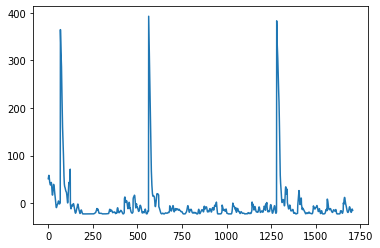

In [20]:
plt.plot(score_all)

Accuracy 	0.9590
AUC score 	0.9877
FAR score 	0.0813
Precision 	0.9187
Recall   	0.8469
Macro F1 	0.9283
weighted F1 	0.9584
Avg Precision 	0.9556
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1401
           1       0.92      0.85      0.88       307

    accuracy                           0.96      1708
   macro avg       0.94      0.92      0.93      1708
weighted avg       0.96      0.96      0.96      1708



[0.9590163934426229,
 0.9877379349789703,
 0.0812720848056537,
 0.9187279151943463,
 0.8469055374592834,
 0.9282929696402653,
 0.958356856616812,
 0.9555955333313867]

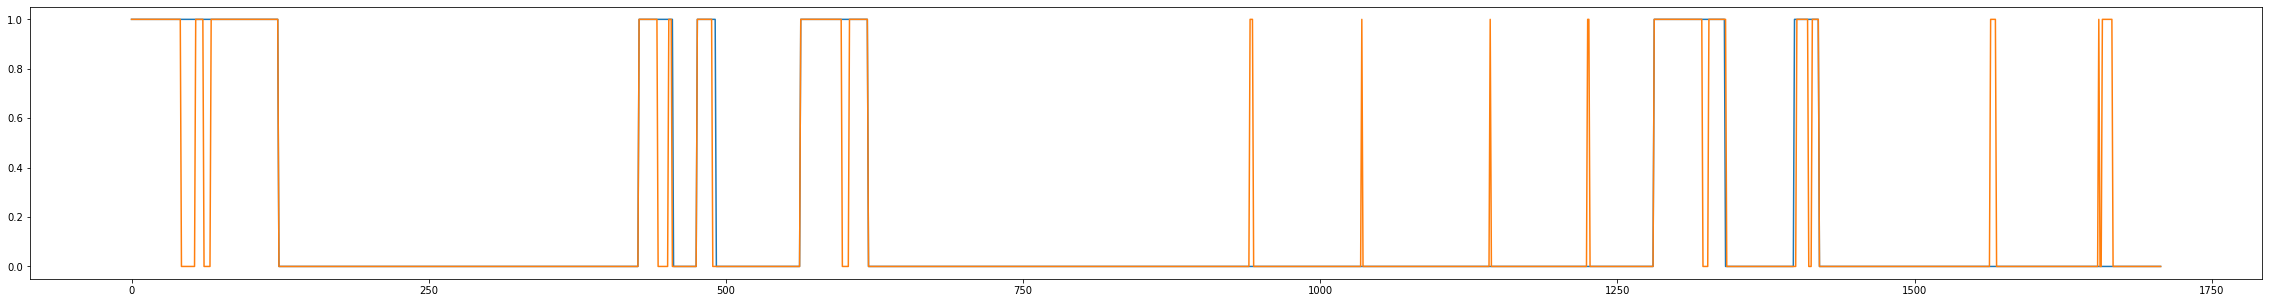

In [21]:
pred = [1 if s > 0 else 0 for s in score_all]
evaluate(label_all, pred, score_all, adjust=False, plot=True, print_=True)

In [22]:
cm = confusion_matrix(label_all, (score_all > 0).astype(int))
cm

array([[1378,   23],
       [  47,  260]])

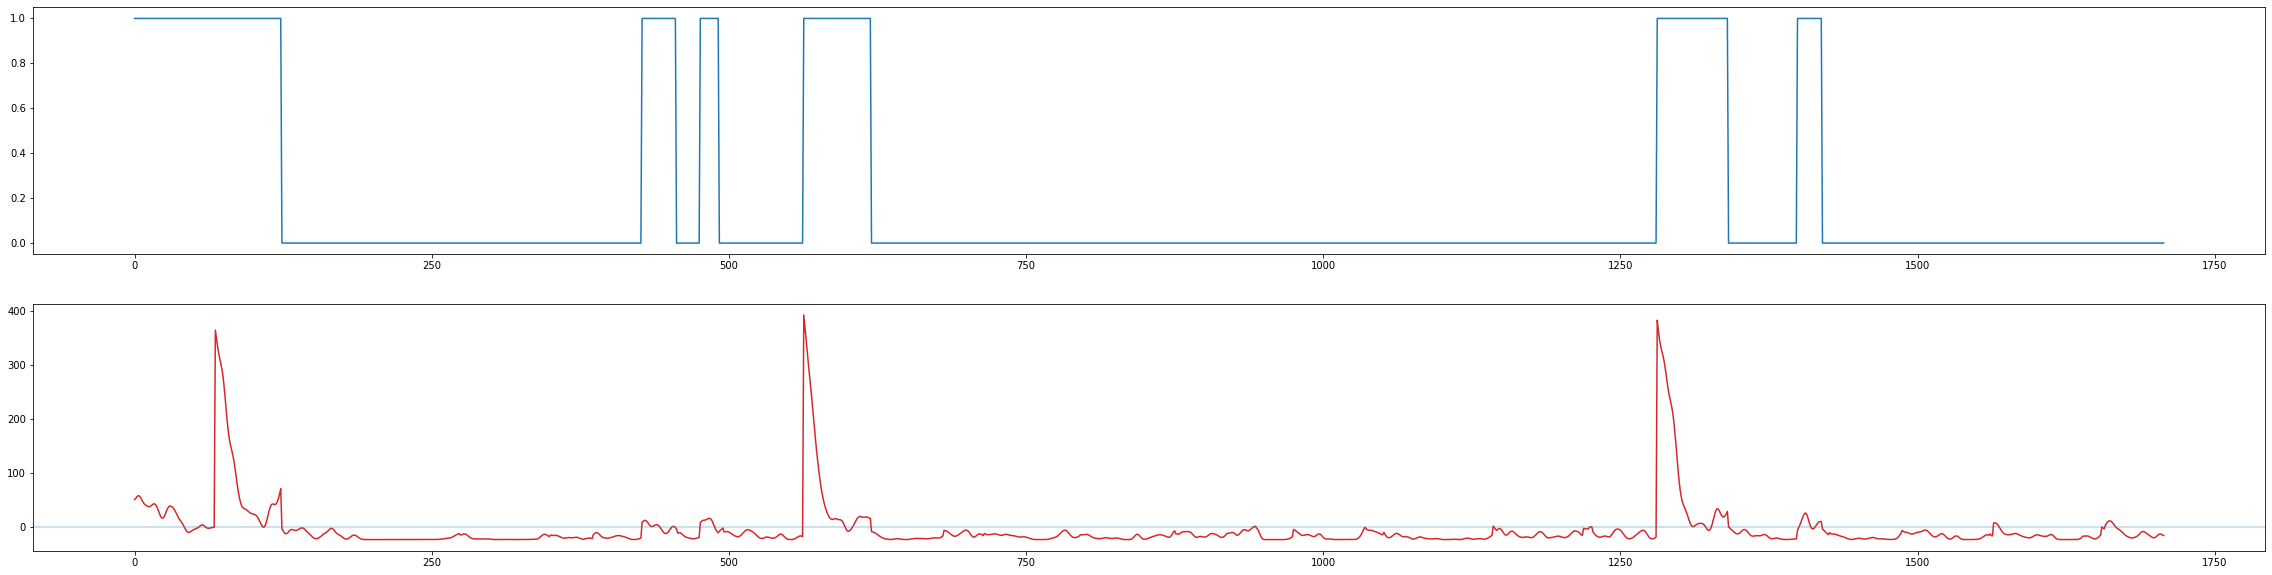

In [23]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


## Case prediction plot

In [127]:
tp = np.where((label_all == 1) & ((score_all > 0).astype(int) == 1))[0]
tmp = np.random.choice(tp, 10)
tmp

array([  34,  123,   91,  442, 1307,  614, 1291, 1408,   14,   29])

In [131]:
fp = np.where((label_all == 0) & ((score_all > 0).astype(int) == 1))[0]
tmp = np.random.choice(fp, 10)
tmp

array([1226, 1659, 1665, 1660, 1664, 1660, 1663, 1662, 1143, 1143])

In [124]:
tn = np.where((label_all == 0) & ((score_all > 0).astype(int) == 0))[0]
tmp = np.random.choice(tn, 10)
tmp

array([1696,  939,  876, 1647,  535, 1186,  918,  961, 1164, 1276])

In [103]:
# detected = np.where(score_all > 100)[0]
# tmp = np.argsort(score_all)[::-1]
tmp = np.random.choice(detected, 10)
tmp

array([ 573,   75, 1291, 1292,   75,   69, 1293, 1285,   81,   72])

In [122]:
data_extraction_path = '/media/usr/HDD/Data/NAVER_df'

with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

test_df = pd.read_csv('../data/{}/test_x.csv'.format(target_sid), index_col=0)
test_df.columns = test_df.columns.astype(int)

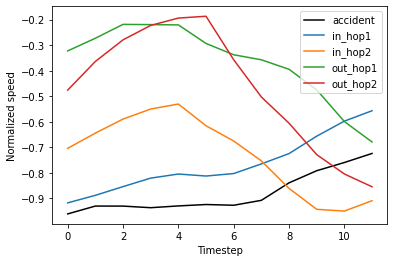

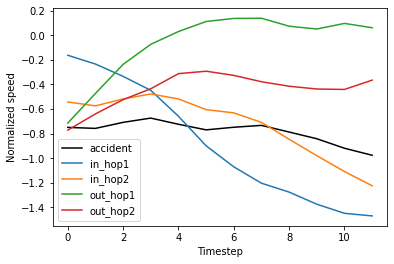

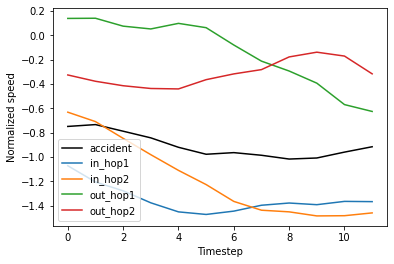

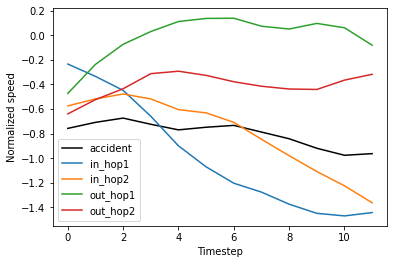

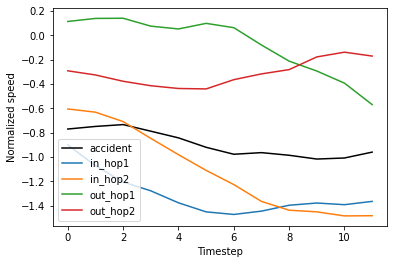

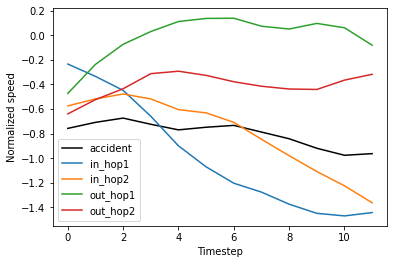

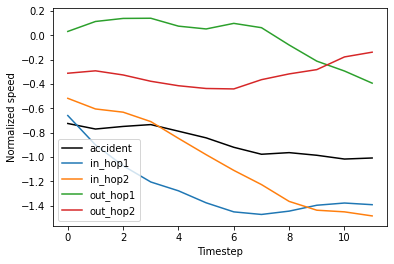

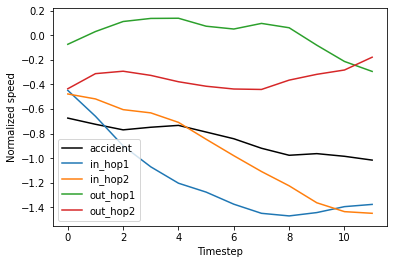

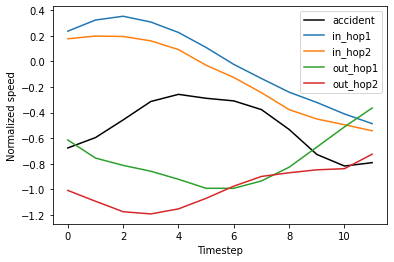

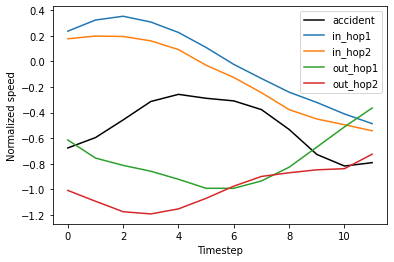

In [132]:
bs = args.batch_size
n_node = 25
for detected in tmp[:10]:
    i = detected // args.batch_size
    j = detected % args.batch_size

    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j], index=test_df.columns.astype(int)).T
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)


    plt.figure()
    plt.plot(df_agg_inflow[0], label='accident', color='k')
    plt.plot(df_agg_inflow[1], label='in_hop1')
    plt.plot(df_agg_inflow[2], label='in_hop2')
    plt.plot(df_agg_outflow[1], label='out_hop1')
    plt.plot(df_agg_outflow[2], label='out_hop2')
    plt.legend()
    plt.ylabel('Normalized speed')
    plt.xlabel('Timestep')
    plt.show()

In [68]:
def speed_agg(test_df):

    df_agg_inflow, df_agg_outflow = [], []
    for hop in [0, 1, 2, 3]:
        inflow = np.unique([p[hop] for p in path_inflow])
        outflow = np.unique([p[hop] for p in path_outflow])
        inflow = [p for p in inflow if p in list(test_df.columns)]
        outflow = [p for p in outflow if p in list(test_df.columns)]
        df_agg_inflow.append(test_df[inflow].mean(axis=1))
        df_agg_outflow.append(test_df[outflow].mean(axis=1))
    df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
    df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

    return df_agg_inflow, df_agg_outflow

### Prediction Case for true incident

In [86]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in list(test_df.columns)]
    outflow = [p for p in outflow if p in list(test_df.columns)]
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

Detected
MTTD =  [25]


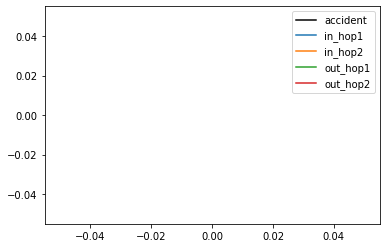

Detected
MTTD =  []


IndexError: index 0 is out of bounds for axis 0 with size 0

In [83]:
st_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == 1)[0]
ed_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == -1)[0][1:]

pred = list(map(int, [s>0 for s in score_all]))

for st, ed in zip(st_time_list, ed_time_list):
    if sum(pred[st:ed]) == 0:
        print('Not detected')
    else:
        print('Detected')
        print('MTTD = ', np.where(np.diff(pred[st:ed], prepend=1)==1)[0])

        i = st + np.where(np.diff(pred[st:ed], prepend=1)==1)[0][0]
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
        plt.legend()
        plt.show()
    

## embedding distribution plot

### Test set

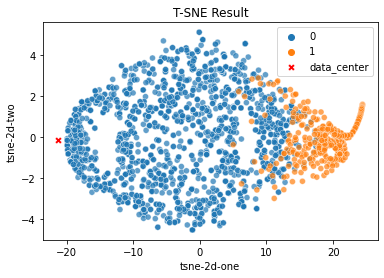

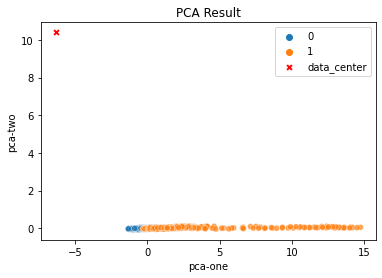

In [133]:
## test set all T-SNE
import seaborn as sns 


normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

rndperm = np.random.choice(normal, 2000)

## add data center
center_arr = data_center.detach().cpu().numpy()
out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=200)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=tsne_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(out_center_all)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=pca_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=pca_df[pca_df.y == -1]['pca-one'], y=pca_df[pca_df.y == -1]["pca-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)


plt.title('PCA Result')
plt.show()

Text(0, 0.5, 'Distance')

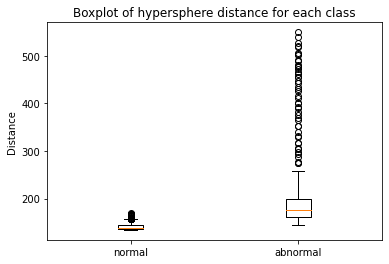

In [134]:
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

/tmp/ipykernel_3014566/2113342768.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


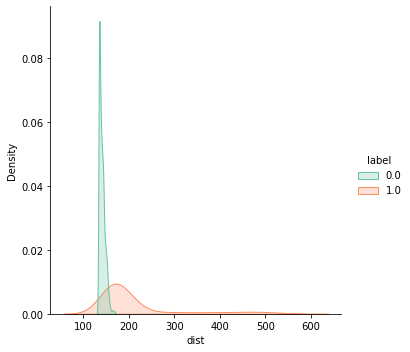

In [135]:
dist_df = pd.DataFrame([dist_all, label_all.reshape(-1)], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

### Train set

In [71]:
out_train, dist_train, score_train = [], [], []
label_train = []
for ix, data in tqdm(enumerate(train_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_train.append(output.cpu().detach().numpy())
    label_train.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, radius)
    dist_train.append(dist.cpu().detach().numpy())
    score_train.append(score.cpu().detach().numpy())
label_train = np.concatenate(label_train)
score_train = np.concatenate(score_train)
dist_train = np.concatenate(dist_train)
out_train = np.concatenate(out_train)

405it [00:02, 196.93it/s]


/tmp/ipykernel_2923519/2179087459.py:20: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


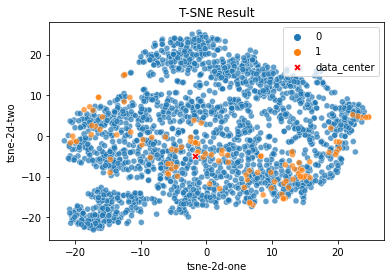

/tmp/ipykernel_2923519/2179087459.py:47: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


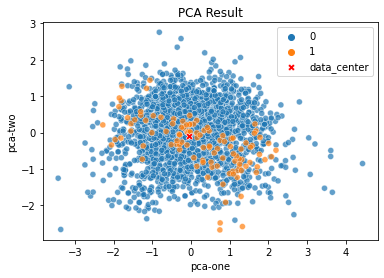

In [72]:
import seaborn as sns 

normal = np.where(label_train == 0)[0]
abnormal = np.where(label_train == 1)[0]
rndperm = np.random.choice(normal, 2000)

## add data center
center_arr = data_center.detach().cpu().numpy()
out_center_all = np.concatenate([out_train[np.concatenate([rndperm, abnormal])], center_arr.reshape(1,-1)])

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(label_train[np.concatenate([rndperm, abnormal])], [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df.iloc[:-1],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()

## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(out_center_all)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = np.append(label_train[np.concatenate([rndperm, abnormal])], [-1])

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=pca_df.iloc[:-1],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=pca_df[pca_df.y == -1]["pca-one"], y=pca_df[pca_df.y == -1]["pca-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('PCA Result')
plt.show()


Text(0, 0.5, 'Distance')

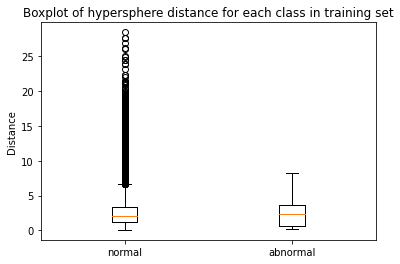

In [73]:
normal = np.where(label_train == 0)[0]
abnormal = np.where(label_train == 1)[0]

plt.boxplot([dist_train[normal], dist_train[abnormal]])
# plt.ylim(0, 1)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class in training set')
plt.ylabel('Distance')

/tmp/ipykernel_2923519/2113342768.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


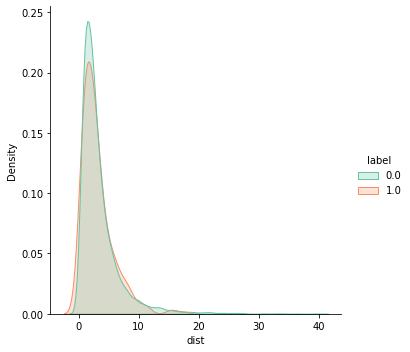

In [74]:
dist_df = pd.DataFrame([dist_all, label_all.reshape(-1)], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

### T-SNE comparison

train dataset


  0%|          | 0/5296 [00:00<?, ?it/s]100%|██████████| 5296/5296 [00:01<00:00, 4067.26it/s]


val dataset


100%|██████████| 1806/1806 [00:00<00:00, 4165.55it/s]


test dataset


100%|██████████| 1708/1708 [00:00<00:00, 3807.74it/s]


42 15 14
Parameter number of GCN_gc Net is: 7072
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GCN_sum_0.2_True+bestcheckpoint.pt


15it [00:00, 143.72it/s]


[18.561085 15.38224  16.98914  13.123442 10.198965]


14it [00:00, 182.26it/s]


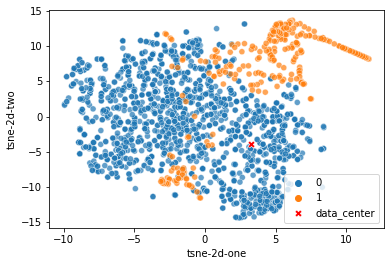

Parameter number of GAT_gc Net is: 287840
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GAT_sum_0.2_True+bestcheckpoint.pt


15it [00:00, 133.70it/s]


[1.3132875  1.0755543  0.808835   0.51538545 0.3068847 ]


14it [00:00, 158.61it/s]


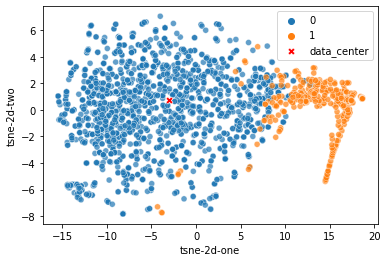

Parameter number of GraphSAGE_gc Net is: 13984
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_GraphSAGE_sum_0.2_True+bestcheckpoint.pt


15it [00:00, 176.57it/s]


[ 97.91554  99.0336   92.77359 103.34362 105.85169]


14it [00:00, 164.41it/s]


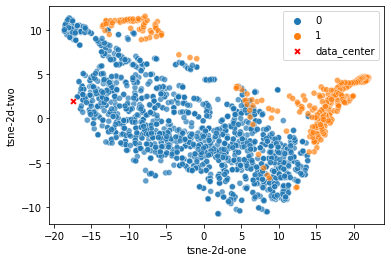

Parameter number of STGCN Net is: 1460
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGCN_sum_0.2_True+bestcheckpoint.pt


15it [00:00, 40.85it/s]


[1482.3872 1501.363  1523.944  1547.628  1560.8029]


14it [00:00, 59.93it/s]


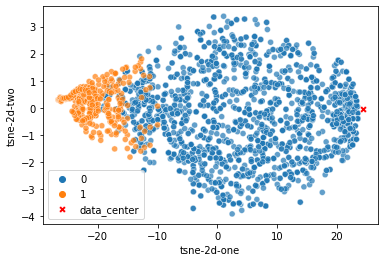

Parameter number of STGAT Net is: 3692
./checkpoints_SAD_bias/1210005301_mtsc/1210005301_mtsc_STGAT_sum_0.2_True+bestcheckpoint.pt


15it [00:00, 49.13it/s]


[62.815937 62.792553 62.879963 63.02221  63.053955]


14it [00:00, 56.86it/s]


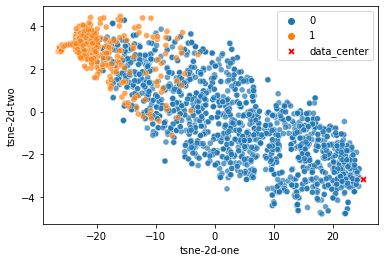

In [14]:
args.dataset = '1210005301_mtsc'
train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))


for module, name in zip(['GCN_gc', 'GAT_gc', 'GraphSAGE_gc', 'STGCN', 'STGAT'], ['GCN','GAT', 'GraphSAGE', 'STGCN', 'STGAT']):
# for module, name in zip(['GraphSAGE_gc'], ['GraphSAGE']):
    
    args.module = module
    name = name
    args.normalize = 'standard'
    args.nu = 0.2
    args.pooling = 'sum'
    args.reverse = False
    args.self_loop = 'True'
    args.bias = True

    args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

    checkpoints_path=f'./checkpoints_SAD_bias/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
    
    input_dim = 12
    model = init_model(args, input_dim)
    print(checkpoints_path)

    model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
    model.to(device=f'cuda:{args.gpu}')
    model.eval()
    data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
    radius = torch.load(checkpoints_path, map_location='cuda')['radius']


    out_all, dist_all, score_all = [], [], []
    label_all = []
    for ix, data in tqdm(enumerate(val_loader)):
        output = model(data.to(device=f'cuda:{args.gpu}'))
        out_all.append(output.cpu().detach().numpy())
        label_all.append(data.y.cpu().detach().numpy())
        # dist, score = anomaly_score(data_center, output, radius)
        dist = torch.sum((output - data_center) ** 2, dim=1)
        dist_all.append(dist.cpu().detach().numpy())
    dist_all = np.concatenate(dist_all)
    print(dist_all[:5])
    # new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
    new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
    new_radius


    out_all, dist_all, score_all = [], [], []
    label_all = []
    for ix, data in tqdm(enumerate(test_loader)):
        output = model(data.to(device=f'cuda:{args.gpu}'))
        out_all.append(output.cpu().detach().numpy())
        label_all.append(data.y.cpu().detach().numpy())
    label_all = np.concatenate(label_all)

    

    ## test set all T-SNE
    import seaborn as sns 


    normal = np.where(label_all == 0)[0]
    abnormal = np.where(label_all == 1)[0]

    rndperm = np.random.choice(normal, 2000)

    ## add data center
    center_arr = data_center.detach().cpu().numpy()
    out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

    ## tSNE
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, perplexity=200)
    tsne_all = tsne.fit_transform(out_center_all)

    tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
    tsne_df['y'] = np.append(label_all, [-1])

    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("tab10", 2),
        data=tsne_df.loc[np.append(rndperm, abnormal), :],
        legend="full",
        alpha=0.7
    )
    sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
        color='red',
        marker='X',
        s=50,
        label='data_center'
    )

    # plt.title('T-SNE plot for DeepSAD with {}'.format(name))
    
    plt.savefig('../images/tsne_DeepSAD+{}.png'.format(name), dpi=250, bbox_inches='tight')
    # plt.savefig('../images/tsne_DeepSAD+{}.pdf'.format(name), dpi=250, bbox_inches='tight')
    plt.show()
    

# All Incidents

In [15]:
# out_1 = pd.read_csv('result/1210005301_mtsc_SAD_sumpool.csv', index_col=0)
# out_2 = pd.read_csv('result/1030001902_mtsc_SAD_sumpool.csv', index_col=0)
# out_3 = pd.read_csv('result/1220005401_mtsc_SAD_sumpool.csv', index_col=0)
# out_4 = pd.read_csv('result/1210003000_mtsc_SAD_sumpool.csv', index_col=0)
# out_5 = pd.read_csv('result/1130052300_mtsc_SAD_sumpool.csv', index_col=0)

out_1 = pd.read_csv('result/1210005301_mtsc_bias_SAD_sumpool.csv', index_col=0)
out_2 = pd.read_csv('result/1030001902_mtsc_bias_SAD_sumpool.csv', index_col=0)
out_3 = pd.read_csv('result/1220005401_mtsc_bias_SAD_sumpool.csv', index_col=0)
out_4 = pd.read_csv('result/1210003000_mtsc_bias_SAD_sumpool.csv', index_col=0)
out_5 = pd.read_csv('result/1130052300_mtsc_bias_SAD_sumpool.csv', index_col=0)

In [16]:
out_1 = out_1[out_1.adjust == False]
out_2 = out_2[out_2.adjust == False]
out_3 = out_3[out_3.adjust == False]
out_4 = out_4[out_4.adjust == False]
out_5 = out_5[out_5.adjust == False]

In [17]:
tmp = np.nanmean([out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:], out_4.iloc[:,4:], out_5.iloc[:,4:]], axis=0)
tmp = pd.DataFrame(tmp, columns=out_1.columns[4:], index=out_1.index)
out_all = pd.concat([out_1.iloc[:, :4], tmp], axis=1)
out_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.048084,0.261458,0.590833,0.048084,0.872055,0.762833,0.502665,0.822141,0.456109
2,GAT,standard,0.01,False,0.038613,0.256957,0.743043,0.038613,0.876671,0.744849,0.502305,0.825384,0.452986
4,GraphSAGE,standard,0.01,False,0.145531,0.081454,0.918546,0.145531,0.882245,0.837838,0.569176,0.838270,0.635157
6,STGCN,standard,0.01,False,0.085599,0.129524,0.870476,0.085599,0.882720,0.850157,0.543290,0.837878,0.597060
8,GCN,standard,0.05,False,0.211011,0.341421,0.658579,0.211011,0.887780,0.772955,0.623774,0.864192,0.507962
10,GAT,standard,0.05,False,0.178313,0.291387,0.708613,0.178313,0.890624,0.802045,0.609382,0.861597,0.531533
12,GraphSAGE,standard,0.05,False,0.242393,0.432561,0.567439,0.242393,0.867513,0.677787,0.608953,0.850395,0.490810
14,STGCN,standard,0.05,False,0.212911,0.322682,0.677318,0.212911,0.886247,0.769656,0.624189,0.863951,0.568025
16,GCN,standard,0.10,False,0.354728,0.464950,0.535050,0.354728,0.876233,0.743856,0.670625,0.872958,0.477589
18,GAT,standard,0.10,False,0.362701,0.467938,0.532062,0.362701,0.884326,0.766815,0.677908,0.878353,0.495761


In [40]:
out_all.to_csv('result/mtsc_bias_out_all.csv')

In [41]:
tmp = np.nanstd([out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:], out_4.iloc[:,4:], out_5.iloc[:,4:]], axis=0)
tmp = pd.DataFrame(tmp, columns=out_1.columns[4:], index=out_1.index)
out_all = pd.concat([out_1.iloc[:, :4], tmp], axis=1)
out_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.051939,0.293822,0.395394,0.051939,0.044983,0.114894,0.038227,0.068262,0.271039
2,GAT,standard,0.01,False,0.025303,0.293735,0.293735,0.025303,0.047077,0.152059,0.024849,0.067145,0.310647
4,GraphSAGE,standard,0.01,False,0.167076,0.140315,0.140315,0.167076,0.051109,0.083607,0.101959,0.077700,0.195829
6,STGCN,standard,0.01,False,0.057736,0.124117,0.124117,0.057736,0.046990,0.117072,0.048999,0.065442,0.305385
8,GCN,standard,0.05,False,0.069723,0.322346,0.322346,0.069723,0.026555,0.131772,0.053518,0.035394,0.282944
10,GAT,standard,0.05,False,0.070086,0.299336,0.299336,0.070086,0.029550,0.139044,0.046555,0.039655,0.310231
12,GraphSAGE,standard,0.05,False,0.199475,0.384255,0.384255,0.199475,0.014937,0.254995,0.091190,0.033991,0.320409
14,STGCN,standard,0.05,False,0.065143,0.364731,0.364731,0.065143,0.024435,0.235499,0.055130,0.032072,0.323186
16,GCN,standard,0.10,False,0.113098,0.341196,0.341196,0.113098,0.039581,0.169027,0.103775,0.034836,0.309236
18,GAT,standard,0.10,False,0.128549,0.308833,0.308833,0.128549,0.031319,0.143199,0.091379,0.029792,0.296411


In [42]:
out_all.to_csv('result/mtsc_bias_out_std.csv')